refer: 

https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min

https://www.kaggle.com/code/ayushnitb/cifar10-custom-resnet-cnn-pytorch-97-acc

In [1]:
import os
import torch 
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import pandas as pd
import shutil
import random
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim


# Data Extraction and Reorganization

In [2]:
# manully download the dataset
data_dir = 'D:/Learning/Data/dataset/CIFAR-10'
print(os.listdir(data_dir))

data_train_dir = data_dir + "/train"
data_test_dir = data_dir + "/test"
data_valid_dir = data_dir + "/valid"

# 创建 valid 文件夹，如果不存在
os.makedirs(data_valid_dir, exist_ok=True)

classes = os.listdir(data_train_dir)
print(classes)

['sampleSubmission.csv', 'test', 'train', 'trainLabels.csv', 'valid']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
'''
# 读取trainLabels.csv文件
labels_csv_path = os.path.join(data_dir, 'trainLabels.csv')
labels_df = pd.read_csv(labels_csv_path)

# 确保标签文件夹存在
for label in labels_df['label'].unique():
    label_folder = os.path.join(data_train_dir, label)
    if not os.path.exists(label_folder):
        os.makedirs(label_folder)

# 移动图片到对应的标签文件夹中
for idx, row in labels_df.iterrows():
    img_id = row['id']
    label = row['label']
    
    # 源图片路径，假设图片后缀是 .png
    src_img_path = os.path.join(data_train_dir, f'{img_id}.png')
    
    # 目标图片路径
    dst_img_path = os.path.join(data_train_dir, label, f'{img_id}.png')
    
    # 移动图片到对应的标签文件夹
    if os.path.exists(src_img_path):
        shutil.move(src_img_path, dst_img_path)

print("图片移动完成！")

# 遍历 train 目录下的每个类别文件夹
for class_name in os.listdir(data_train_dir):
    class_train_dir = os.path.join(data_train_dir, class_name)
    
    # 确保是目录
    if os.path.isdir(class_train_dir):
        # 创建对应的 valid 类别文件夹
        class_valid_dir = os.path.join(data_valid_dir, class_name)
        os.makedirs(class_valid_dir, exist_ok=True)
        
        # 获取当前类别文件夹中的所有图片文件
        images = [img for img in os.listdir(class_train_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        
        # 随机选择 20% 的图片进行移动
        num_images = len(images)
        num_valid = int(0.2 * num_images)
        valid_images = random.sample(images, num_valid)
        
        # 将选定的图片移动到 valid 类别文件夹
        for img in valid_images:
            src_img_path = os.path.join(class_train_dir, img)
            dst_img_path = os.path.join(class_valid_dir, img)
            shutil.move(src_img_path, dst_img_path)
        
        print(f"Moved {num_valid} images from {class_name} to valid/{class_name}")
'''

'\n# 读取trainLabels.csv文件\nlabels_csv_path = os.path.join(data_dir, \'trainLabels.csv\')\nlabels_df = pd.read_csv(labels_csv_path)\n\n# 确保标签文件夹存在\nfor label in labels_df[\'label\'].unique():\n    label_folder = os.path.join(data_train_dir, label)\n    if not os.path.exists(label_folder):\n        os.makedirs(label_folder)\n\n# 移动图片到对应的标签文件夹中\nfor idx, row in labels_df.iterrows():\n    img_id = row[\'id\']\n    label = row[\'label\']\n    \n    # 源图片路径，假设图片后缀是 .png\n    src_img_path = os.path.join(data_train_dir, f\'{img_id}.png\')\n    \n    # 目标图片路径\n    dst_img_path = os.path.join(data_train_dir, label, f\'{img_id}.png\')\n    \n    # 移动图片到对应的标签文件夹\n    if os.path.exists(src_img_path):\n        shutil.move(src_img_path, dst_img_path)\n\nprint("图片移动完成！")\n\n# 遍历 train 目录下的每个类别文件夹\nfor class_name in os.listdir(data_train_dir):\n    class_train_dir = os.path.join(data_train_dir, class_name)\n    \n    # 确保是目录\n    if os.path.isdir(class_train_dir):\n        # 创建对应的 valid 类别文件夹\n        c

# Data Preparation

## Use test set for validation
我们将简单地使用测试集作为验证集，而不是从训练集中留出一小部分（例如10%）的数据进行验证。这只是为训练提供了更多的数据。一般来说，一旦你使用固定的验证集选择了最好的模型架构和超参数，在整个数据集上重新训练相同的模型是一个好主意，只是为了给它一个小小的性能提升。

## Channel-wise data normalization
通道数据归一化：我们将通过减去平均值并除以每个通道的标准偏差来归一化图像张量。因此，每个通道的数据均值为0，标准差为1。规范化数据可以防止来自任何一个通道的值在训练时不成比例地影响损失和梯度，只需具有比其他通道更高或更宽的值范围。

## Randomized data augmentations
随机数据增强：我们将在从训练数据集加载图像时应用随机选择的转换。具体来说，我们将每张图像填充4个像素，然后随机裁剪大小为32 x 32像素，然后以50%的概率水平翻转图像。由于每次加载特定图像时都会随机动态地应用变换，因此模型在每个训练历元中看到的图像略有不同，这使得它可以更好地进行泛化。

在CIFAR-10数据集中，数据预处理通常包括归一化和数据增强（Data Augmentation）两部分。你提供的代码中，通过`torchvision.transforms`（简称`tt`）实现了这些操作。下面是对代码的详细解释：

### 1. **归一化（Normalization）**
   - CIFAR-10 的图像是 32x32 大小的彩色图像，像素值范围在 `[0, 1]` 或 `[0, 255]` 之间。
   - 归一化是将图像的像素值通过减去均值并除以标准差，使其符合标准正态分布。
   
   ```python
   stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
   ```
   - 这里的 `stats` 变量包含了每个通道（RGB）的均值和标准差：
     - **均值**： `(0.4914, 0.4822, 0.4465)` 对应于 RGB 通道的均值。
     - **标准差**： `(0.2023, 0.1994, 0.2010)` 对应于 RGB 通道的标准差。
   - 这些值是通过对整个 CIFAR-10 数据集统计得到的，用于将图像像素值归一化。

### 2. **数据增强（Data Augmentation）**
   数据增强用于提高模型的泛化能力，通过随机变换图像来生成不同的训练样本。这对模型训练有帮助，尤其是在数据集较小时。

   ```python
   train_tfms = tt.Compose([
       tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
       tt.RandomHorizontalFlip(), 
       tt.ToTensor(), 
       tt.Normalize(*stats, inplace=True)
   ])
   ```

   - **`tt.RandomCrop(32, padding=4, padding_mode='reflect')`**：随机裁剪图像为 32x32 的大小，并在每个方向上增加 4 像素的填充。`padding_mode='reflect'` 表示使用反射填充边缘区域。
   - **`tt.RandomHorizontalFlip()`**：随机水平翻转图像（以 50% 的概率）。这种水平翻转在很多场景中可以保留图像的主要特征，特别适用于物体不需要有固定方向的任务。
   - **`tt.ToTensor()`**：将图像从 PIL 格式（或 numpy 数组）转换为 PyTorch 张量，并将像素值归一化到 `[0, 1]`。
   - **`tt.Normalize(*stats, inplace=True)`**：使用之前定义的均值和标准差对图像进行归一化，使每个像素的值服从标准正态分布。这一步是在转换为张量之后进行的。

### 3. **验证集预处理**
   验证集的预处理一般比训练集简单，因为不需要数据增强。验证集只需进行归一化即可：

   ```python
   valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
   ```
   - 这里没有使用数据增强，只是将图像转换为张量并归一化。

### 总结
- **训练集**：使用了数据增强（随机裁剪和水平翻转）和归一化。
- **验证集**：只进行了归一化处理。
   
这些预处理步骤帮助模型更好地学习 CIFAR-10 数据集的特征，并且通过数据增强，增加了数据的多样性，减少过拟合的可能性。

见experiments/Transforms.ipynb



In [24]:
# Data transform (normalization and data augmentation)
# CIFAR 数据集的均值
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# transforms_train = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode="reflect"),
#                                tt.RandomHorizontalFlip(),
#                                tt.ToTensor(),
#                                tt.Normalize(*stats, inplace=True)])

transforms_train = tt.Compose([tt.ToTensor(),
                               tt.Normalize(*stats, inplace=True)])

transforms_valid = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [25]:
# PyTorch datasets
train_ds = ImageFolder(data_train_dir, transforms_train)
valid_ds = ImageFolder(data_valid_dir, transforms_valid)
print(type(train_ds)==type(valid_ds))

True


In [6]:
batch_size = 400

In [26]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [27]:
# define a method to show images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


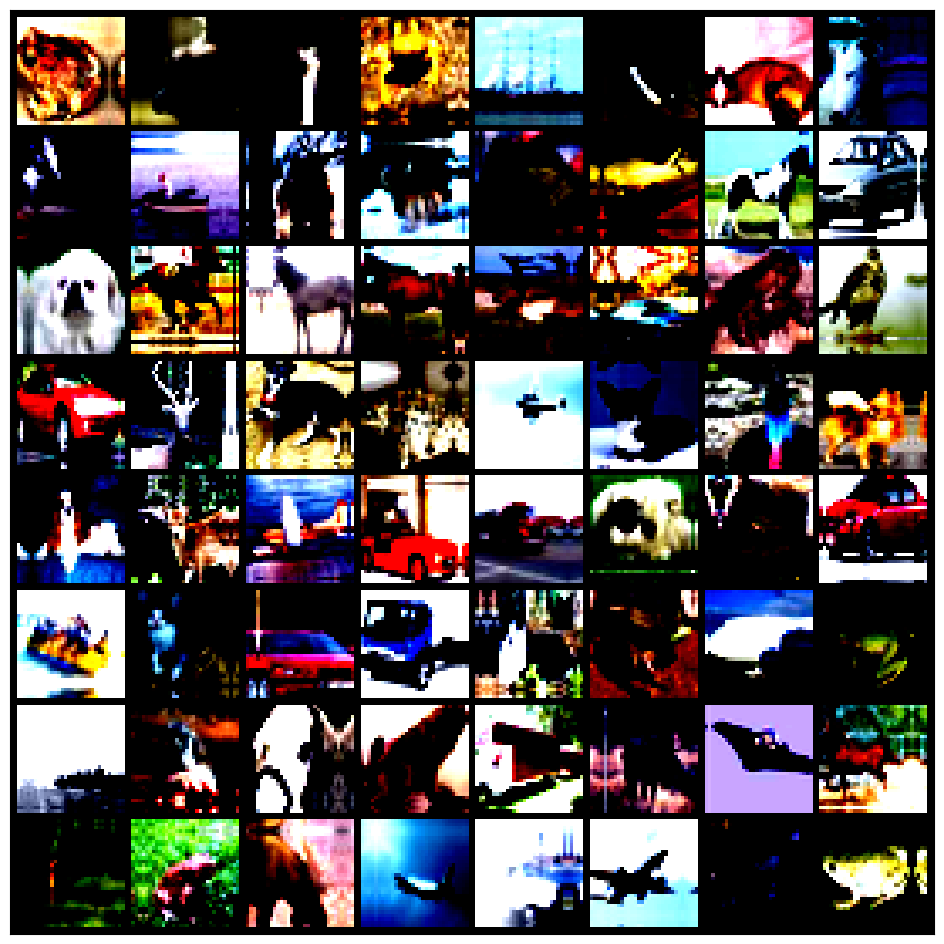

In [9]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


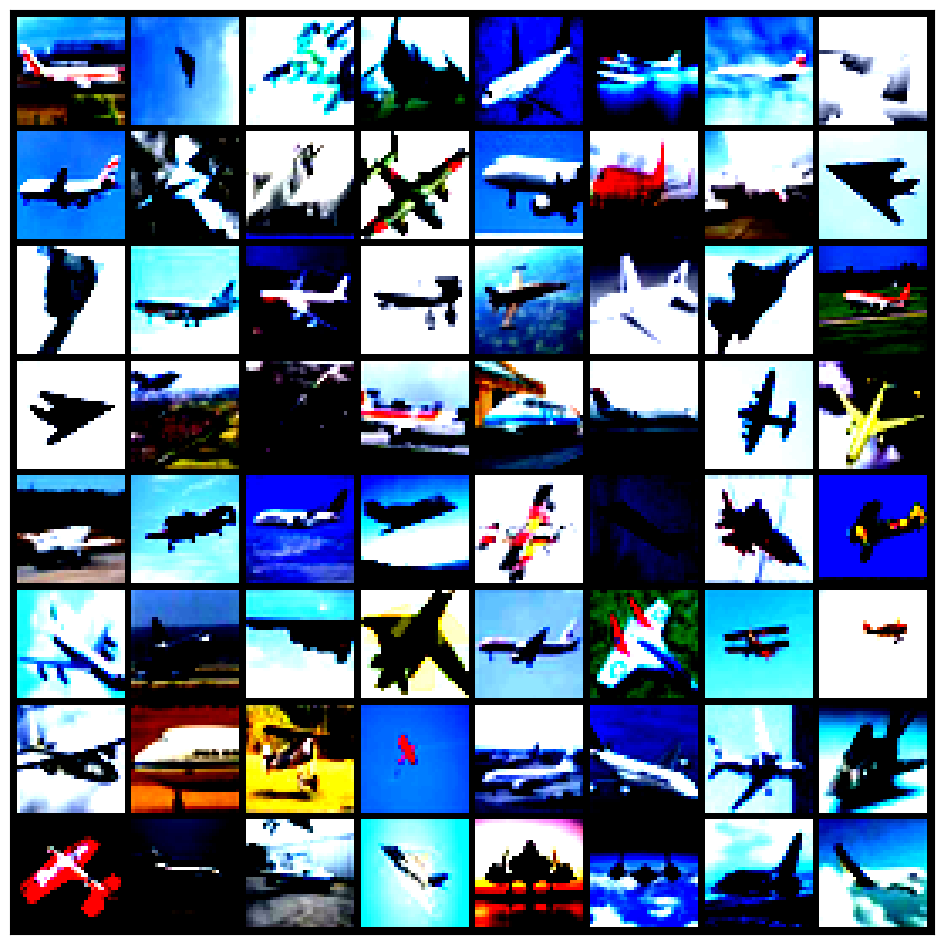

In [10]:
show_batch(valid_dl)

In [11]:
if torch.cuda.is_available():
    print(torch.device('cuda'))
else:
    print(torch.device('cpu'))

cuda


In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [13]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

cuda


## ResNet pretrained model

In [15]:
resnet_model = models.resnet18(pretrained=True)
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

d:\DevKits\Anaconda3\envs\dl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DevKits\Anaconda3\envs\dl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
# freeze all layers parameters except the last one
for param in resnet_model.parameters():
    param.requires_grad = False

# replace the last fully connected layer
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 10)

# only train the last layer
for param in resnet_model.fc.parameters():
    param.requires_grad = True
    
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


In [18]:
resnet_model.cuda

<bound method Module.cuda of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
history = [evaluate(resnet_model, valid_dl)]
history

AttributeError: 'ResNet' object has no attribute 'validation_step'

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

In [20]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 清除梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)

        # 反向传播
        loss.backward()

        # 更新参数
        optimizer.step()

        running_loss += loss.item()

    print(f"Training loss: {running_loss / len(train_loader)}")

In [31]:
for i in range(10):
    train(resnet_model, train_dl, optimizer, criterion, device)

Training loss: 1.7976406800746918
Training loss: 1.5842491507530212
Training loss: 1.5519340658187866
Training loss: 1.5347647368907928
Training loss: 1.5206304466724396
Training loss: 1.5158925223350526
Training loss: 1.512117816209793
Training loss: 1.5077768743038178
Training loss: 1.5113967096805572
Training loss: 1.5090772211551666


In [22]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # 设置为评估模式
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            # 将输入和标签移动到GPU（或CPU）
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return val_loss / len(val_loader), accuracy

In [32]:
validate_model(resnet_model, valid_dl, criterion, device)

(1.5668724683614879, 0.4592)